# 1.Load the Data

In [1]:
#impoart libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import re
import string
import random
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import  f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc,ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from itertools import product
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
#load the data
df = pd.read_csv('Combined Data.csv')

In [6]:
#Drop NULLs
df.dropna(inplace = True)

In [7]:
df.shape

(52681, 3)

In [8]:
df = df.iloc[:,1:]

In [9]:
df.describe().T

,count,unique,top,freq
statement,52681,51073,what do you mean?,22
status,52681,7,Normal,16343


In [10]:
#As we are going to do multi-class classifications here, simple label encode the df
import joblib
label_encoder = joblib.load('le.pkl') #LabelEncoder()
df['encoded_status'] = label_encoder.fit_transform(df['status'])


In [11]:
#shuffle the data
# random.seed(1234)
# df = shuffle(df)
# df

After bacis cleaning dropping the NULLs, the data contains 52681 records with 2 columns, statement \(text\) and status \(status\) .
There are 7 unique status, we use a simple label encoding to represent this

# 3.Modeling

## 3.1 Classical ML Model

### 3.1.0 Pre-processing for classical ML Models


In [12]:
#make a copy of data especially for classical ML Models
df1 = df.copy()

In [13]:
# Step 1: Clean the Text
# Purpose: Removes noise (e.g., special characters, extra spaces) that doesn't contribute to understanding the text's meaning.
def clean_text(text):
    """Cleans input text from social media for NLP models.

    Args:
        text (str): The input text.

    Returns:
        str: The cleaned text.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df1['statement'] = df1['statement'].apply(clean_text)

In [14]:
#Step 2: stopwords removal
#Stop words (e.g., "and", "is", "the") do not carry much meaning and can be removed to reduce noise.
stop_words = set(stopwords.words('english'))
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [15]:
#Step 3：lemmatize
# Reduces words to their base or root forms, ensuring that variations of the same word are treated equally (e.g., "running", "runs", "ran" → "run").
lemmatizer = WordNetLemmatizer()
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [16]:
#Step 4: Train-Test Split
#Random sample, use 20% data for test, 80% data for train
X1 = df['statement']
y1 = df['encoded_status']
random.seed(1234)
# Initial train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X1.tolist(), y1.tolist(), test_size=0.2, random_state=42
)

# Further split training data into training and validation sets
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(
    X_train_1, y_train_1, test_size=0.25, random_state=42  # for validation: 0.25 * 0.8 = 0.2 of original data
)


In [17]:
# Step 5: TF-IDF Vectorization
#Converts raw text into numerical features for input to ML models
# joblib.load('tfidf_vectorizer_1.pkl')
tfidf = joblib.load('tfidf_vectorizer_1.pkl') #TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_train_tfidf_1 = tfidf.transform(X_train_1)  # Fit on training data
X_test_tfidf_1 = tfidf.transform(X_test_1)       # Transform test data
#joblib.dump(tfidf,"tfidf_vectorizer_1.pkl")
# Initialize the TF-IDF Vectorizer
tfidf = joblib.load('tfidf_vectorizer_2.pkl')#TfidfVectorizer(max_features=10000, stop_words='english')
#joblib.load('tfidf_vectorizer_2.pkl')

# Fit TF-IDF on training data
#tfidf.fit(X_train_1)
#joblib.dump(tfidf,"tfidf_vectorizer_2.pkl")
# Transform train, validation, and test sets
X_train_1= tfidf.transform(X_train_1)
X_val_1 = tfidf.transform(X_val_1)
X_test_1 = tfidf.transform(X_test_1)

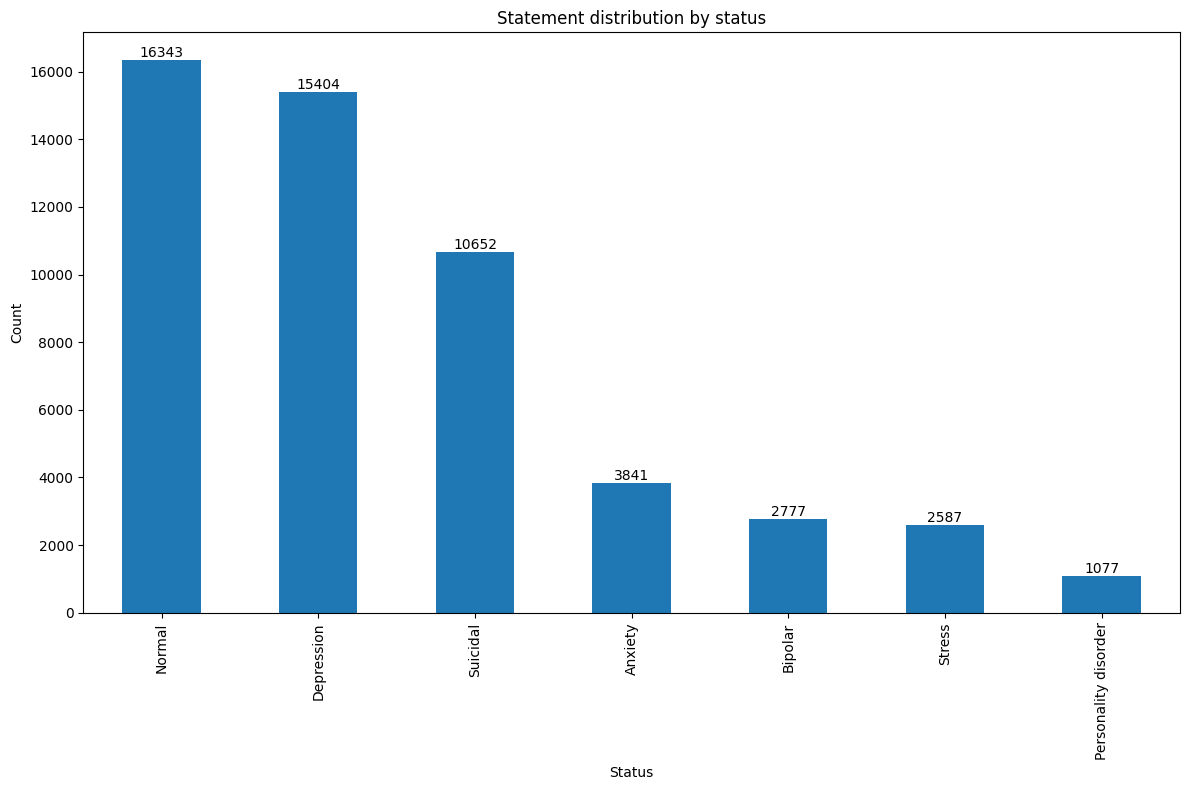

In [14]:
#Step 6: Handeling class-imbalance
# As shown by below plot, there are class-imbalance issues
# Therefore, we would need to balance the class distribution in the training set, we will do so by using a balanced class weights in training
plt.figure(figsize=(12,8))
status_counts = df1['status'].value_counts()
ax = status_counts.plot(kind='bar')
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 3.1.0 SVM

In [ ]:
random.seed(1234)

# Reduced parameter grid
param_grid = {
    'C': [0.1, 1, 10],            # Regularization strength
    'kernel': ['linear', 'rbf'],  # Commonly used kernels
    'class_weight': ['balanced',None], # Handle class imbalance
    'gamma': ['scale'],           # Default kernel coefficient
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for C, kernel, class_weight, gamma in product(param_grid['C'], param_grid['kernel'], param_grid['class_weight'], param_grid['gamma']):
    try:
        # Create the SVM model with current parameters
        model = SVC(C=C, kernel=kernel, class_weight=class_weight, gamma=gamma, random_state=42)

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {'C': C, 'kernel': kernel, 'class_weight': class_weight, 'gamma': gamma}
    except Exception as e:
        print(f"Skipping combination C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)


Validation F1-Score for C=0.1, kernel=linear, class_weight=balanced, gamma=scale: 0.7203
Validation F1-Score for C=0.1, kernel=linear, class_weight=None, gamma=scale: 0.6878
Validation F1-Score for C=0.1, kernel=rbf, class_weight=balanced, gamma=scale: 0.6850
Validation F1-Score for C=0.1, kernel=rbf, class_weight=None, gamma=scale: 0.5747
Validation F1-Score for C=1, kernel=linear, class_weight=balanced, gamma=scale: 0.7571
Validation F1-Score for C=1, kernel=linear, class_weight=None, gamma=scale: 0.7600
Validation F1-Score for C=1, kernel=rbf, class_weight=balanced, gamma=scale: 0.7634
Validation F1-Score for C=1, kernel=rbf, class_weight=None, gamma=scale: 0.7560
Validation F1-Score for C=10, kernel=linear, class_weight=balanced, gamma=scale: 0.7421
Validation F1-Score for C=10, kernel=linear, class_weight=None, gamma=scale: 0.7369
Validation F1-Score for C=10, kernel=rbf, class_weight=balanced, gamma=scale: 0.7640
Validation F1-Score for C=10, kernel=rbf, class_weight=None, gamma=

In [ ]:
SVM = SVC(C=10, kernel='rbf', class_weight='balanced', gamma='scale', random_state=42,probability=True)

# Train the model
SVM.fit(X_train_1, y_train_1)

SVC(C=10, class_weight='balanced', probability=True, random_state=42)

In [ ]:
# Load model and encoder
SVM = joblib.load('svm_model_multi.pkl')
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc
)
from sklearn.utils import resample
def bootstrap_auc_ci_multiclass(y_true, y_scores, n_classes, n_iterations=1000, average="macro"):
    auc_scores = []
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        y_true_sample = y_true_bin[indices]
        y_scores_sample = y_scores[indices]
        try:
            auc_sample = roc_auc_score(y_true_sample, y_scores_sample, average=average, multi_class="ovr")
            auc_scores.append(auc_sample)
        except ValueError:
            continue

    return np.mean(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)


def plot_multiclass_roc(y_true, y_score, n_classes, label_prefix="Model"):
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(["blue", "green", "red", "cyan", "magenta", "orange", "darkblue"])
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label_prefix} - Multi-class ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def bootstrap_f1_ci(y_true, y_pred, n_iterations=1000, average='weighted'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1_scores = []
    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        f1 = f1_score(y_true[indices], y_pred[indices], average=average)
        f1_scores.append(f1)

    f1_mean = np.mean(f1_scores)
    ci_lower = np.percentile(f1_scores, 2.5)
    ci_upper = np.percentile(f1_scores, 97.5)
    return f1_mean, ci_lower, ci_upper

def plot_confusion_matrix(y_true, y_pred, labels=['No Issue', 'Issue']):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model_multiclass(model, X_test, y_test, model_name="Model"):
    print(f"\n--- Evaluation Report: {model_name} ---\n")
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # F1 Score with CI
    f1_mean, f1_ci_low, f1_ci_high = bootstrap_f1_ci(y_test, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1_mean:.4f}")
    print(f"95% CI for F1 Score: [{f1_ci_low:.4f}, {f1_ci_high:.4f}]")

    # Confusion Matrix
    labels = list(np.unique(y_test))
    plot_confusion_matrix(y_test, y_pred, labels=labels)

    # ROC & AUC (One-vs-Rest)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        print("Model doesn't support probability or decision scores.")
        return

    n_classes = len(np.unique(y_test))
    auc_score, auc_ci_low, auc_ci_high = bootstrap_auc_ci_multiclass(y_test, y_scores, n_classes)
    print(f"Macro-Averaged AUC: {auc_score:.4f}")
    print(f"95% CI for AUC: [{auc_ci_low:.4f}, {auc_ci_high:.4f}]")

    plot_multiclass_roc(y_test, y_scores, n_classes, label_prefix=model_name)





--- Evaluation Report: SVM ---

Classification Report:
              precision    recall  f1-score   support

           0     0.8276    0.7947    0.8108       755
           1     0.9061    0.6774    0.7752       527
           2     0.6678    0.7444    0.7040      3016
           3     0.8576    0.9429    0.8982      3308
           4     0.9224    0.4515    0.6062       237
           5     0.7554    0.4608    0.5724       536
           6     0.6959    0.6372    0.6652      2158

    accuracy                         0.7640     10537
   macro avg     0.8047    0.6727    0.7189     10537
weighted avg     0.7667    0.7640    0.7593     10537

Weighted F1 Score: 0.7593
95% CI for F1 Score: [0.7505, 0.7680]


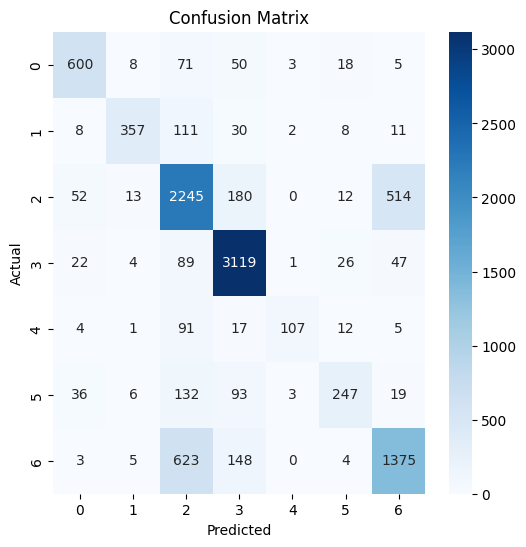

Macro-Averaged AUC: 0.9570
95% CI for AUC: [0.9545, 0.9597]


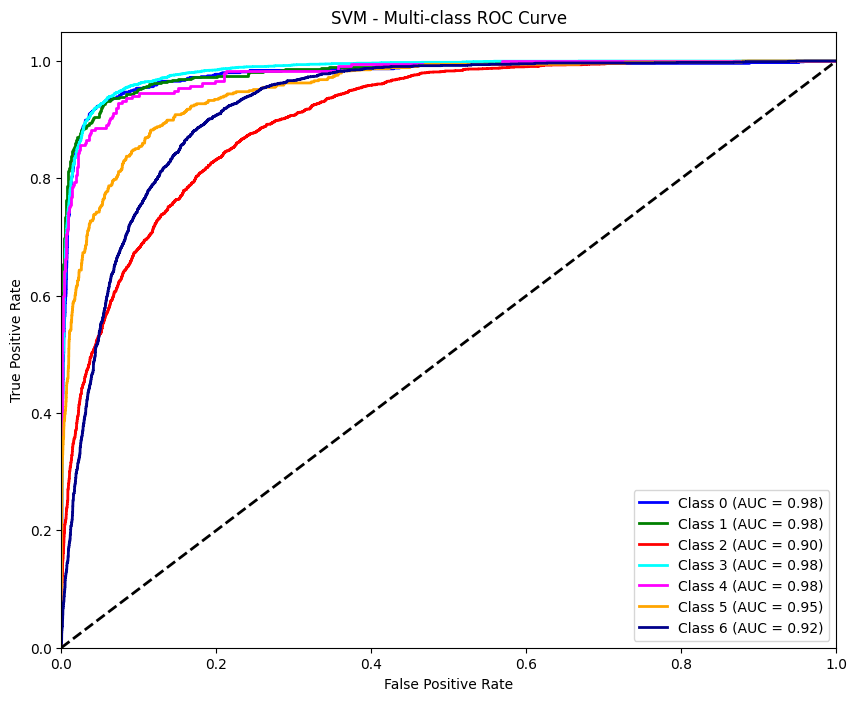

In [ ]:
evaluate_model_multiclass(SVM, X_test_1, y_test_1, model_name="SVM")


### 3.1.1 Logistic Regression

In [ ]:
random.seed(1234)

# Reduced parameter grid for logistic regression
param_grid = {
    'C': [0.1, 1, 10],                # Regularization strength
    'solver': ['lbfgs', 'saga'],      # Optimization solvers
    'penalty': ['l2'],                # L2 regularization
    'multi_class': ['multinomial'],   # Multiclass strategy: using multinomial for multi-class classification
    'class_weight': ['balanced', None],     # Handle class imbalance
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for C, solver, penalty, multi_class, class_weight in product(
        param_grid['C'], param_grid['solver'], param_grid['penalty'], param_grid['multi_class'], param_grid['class_weight']):
    try:
        # Create the Logistic Regression model with current parameters
        model = LogisticRegression(
            C=C,
            solver=solver,
            penalty=penalty,
            multi_class=multi_class,
            class_weight=class_weight,
            max_iter=1000,
            random_state=42
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for C={C}, solver={solver}, penalty={penalty}, multi_class={multi_class}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'C': C,
                'solver': solver,
                'penalty': penalty,
                'multi_class': multi_class,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination C={C}, solver={solver}, penalty={penalty}, multi_class={multi_class}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)


Validation F1-Score for C=0.1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7071
Validation F1-Score for C=0.1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=None: 0.6568
Validation F1-Score for C=0.1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7067
Validation F1-Score for C=0.1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=None: 0.6573
Validation F1-Score for C=1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7492
Validation F1-Score for C=1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=None: 0.7504
Validation F1-Score for C=1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7332
Validation F1-Score for C=1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=None: 0.7503
Validation F1-Score for C=10, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7534
Validation F1-Score f

In [21]:

LR = LogisticRegression(
    C=10,
    solver='lbfgs',
    penalty='l2',
    multi_class='multinomial',
    class_weight=None,
    max_iter=1000,
    random_state=42
)

# Train the model
LR.fit(X_train_1, y_train_1)

LogisticRegression(C=10, max_iter=1000, multi_class='multinomial',
                   random_state=42)


--- Evaluation Report: Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

           0     0.8107    0.7656    0.7875       755
           1     0.8662    0.7002    0.7744       527
           2     0.6644    0.7036    0.6834      3016
           3     0.8643    0.9278    0.8949      3308
           4     0.8421    0.5401    0.6581       237
           5     0.6594    0.5093    0.5747       536
           6     0.6531    0.6316    0.6422      2158

    accuracy                         0.7499     10537
   macro avg     0.7657    0.6826    0.7165     10537
weighted avg     0.7491    0.7499    0.7473     10537

Weighted F1 Score: 0.7474
95% CI for F1 Score: [0.7388, 0.7554]


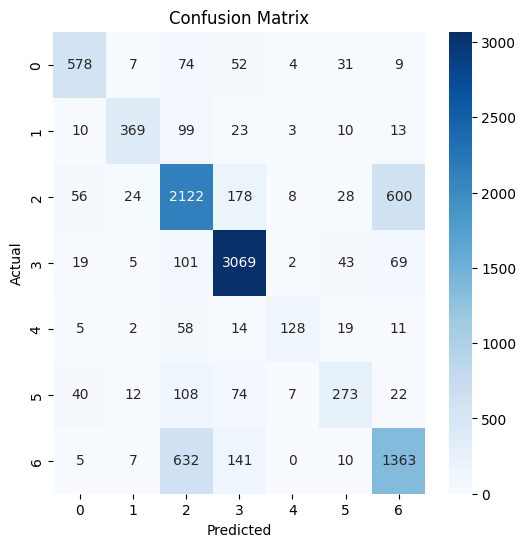

Macro-Averaged AUC: 0.9478
95% CI for AUC: [0.9447, 0.9507]


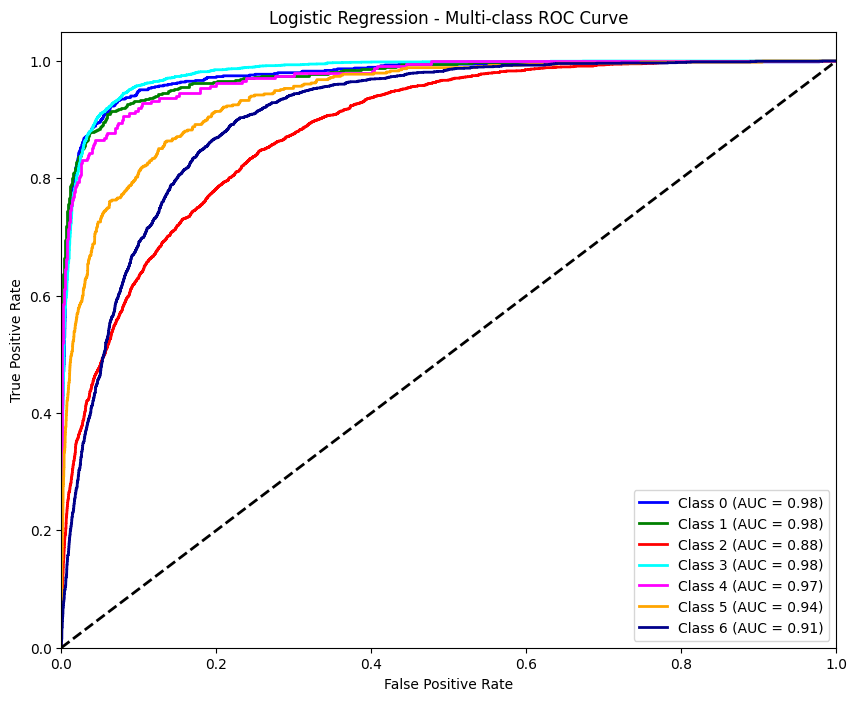

In [ ]:
evaluate_model_multiclass(LR, X_test_1, y_test_1, model_name="Logistic Regression")


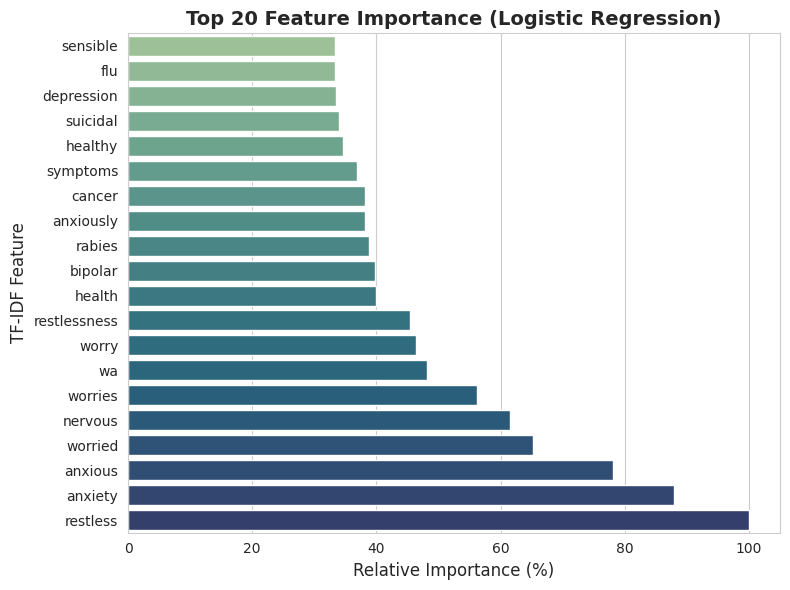

           Feature  Coefficient  Scaled Importance
7448      restless    13.036415         100.000000
628        anxiety    11.468611          87.973660
629        anxious    10.173132          78.036268
9880       worried     8.493128          65.149259
5916       nervous     8.029613          61.593723
9881       worries     7.320559          56.154697
9633            wa    -6.272423          48.114633
9883         worry     6.041529          46.343483
7449  restlessness     5.914689          45.370521
4208        health     5.213109          39.988822
1106       bipolar    -5.179023          39.727354
7038        rabies     5.049302          38.732294
630      anxiously     4.983204          38.225265
1459        cancer     4.973862          38.153599
8741      symptoms     4.807079          36.874241
4214       healthy     4.503954          34.549020
8620      suicidal    -4.435295          34.022353
2488    depression    -4.370392          33.524492
3655           flu     4.353182

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extract feature names
feature_names = tfidf.get_feature_names_out()

# Extract coefficients from the trained Logistic Regression model
coefficients = LR.coef_[0]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Use absolute value for importance
importance_df['Importance (Abs)'] = importance_df['Coefficient'].abs()

# Normalize importance (rescale to 0–100)
importance_df['Scaled Importance'] = (
    importance_df['Importance (Abs)'] / importance_df['Importance (Abs)'].max()
) * 100

# Sort and take top 20
top_20_features = importance_df.sort_values(by='Importance (Abs)', ascending=False).head(20)

# Plot (horizontal bar chart)
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    x='Scaled Importance',
    y='Feature',
    data=top_20_features[::-1],  # Reverse for descending top-down
    palette="crest"
)

plt.title("Top 20 Feature Importance (Logistic Regression)", fontsize=14, fontweight='bold')
plt.xlabel("Relative Importance (%)", fontsize=12)
plt.ylabel("TF-IDF Feature", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save high-res for paper
plt.savefig("top_features_lr.png", dpi=300)
plt.show()

# Optionally print the top 20
print(top_20_features[['Feature', 'Coefficient', 'Scaled Importance']])


### 3.1.2 Random Forest

In [ ]:
random.seed(1234)

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [None, 10, 20],          # Depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required at a leaf node
    'class_weight': ['balanced', None],   # Handle class imbalance
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for n_estimators, max_depth, min_samples_split, min_samples_leaf, class_weight in product(
        param_grid['n_estimators'],
        param_grid['max_depth'],
        param_grid['min_samples_split'],
        param_grid['min_samples_leaf'],
        param_grid['class_weight']):
    try:
        # Create the Random Forest model with current parameters
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight=class_weight,
            random_state=42
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)



Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=balanced: 0.6993
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=None: 0.6787
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, class_weight=balanced: 0.7350
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, class_weight=None: 0.6781
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4, class_weight=balanced: 0.7181
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4, class_weight=None: 0.6479
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1, class_weight=balanced: 0.7237
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1, class_weight=None:

In [18]:
# Create the Random Forest model with current parameters
RandomForest = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# Train the model
RandomForest.fit(X_train_1, y_train_1)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=200, random_state=42)


--- Evaluation Report: RandomForest ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7140    0.8066    0.7575       755
           1     0.8036    0.7685    0.7856       527
           2     0.7027    0.6472    0.6738      3016
           3     0.8769    0.9129    0.8945      3308
           4     0.9015    0.5021    0.6450       237
           5     0.5929    0.4646    0.5209       536
           6     0.6347    0.7076    0.6691      2158

    accuracy                         0.7479     10537
   macro avg     0.7466    0.6871    0.7066     10537
weighted avg     0.7482    0.7479    0.7453     10537

Weighted F1 Score: 0.7454
95% CI for F1 Score: [0.7369, 0.7544]


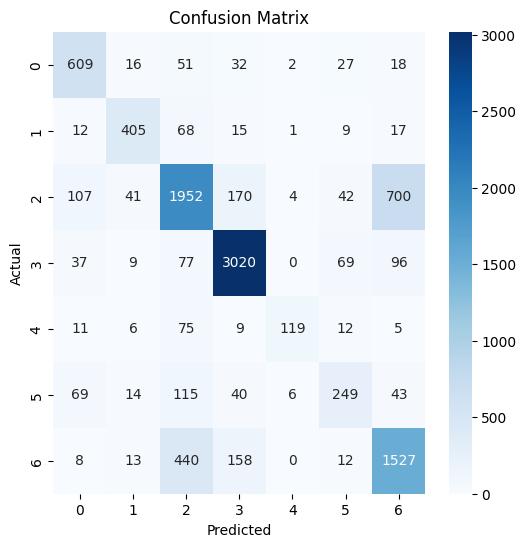

Macro-Averaged AUC: 0.9434
95% CI for AUC: [0.9399, 0.9464]


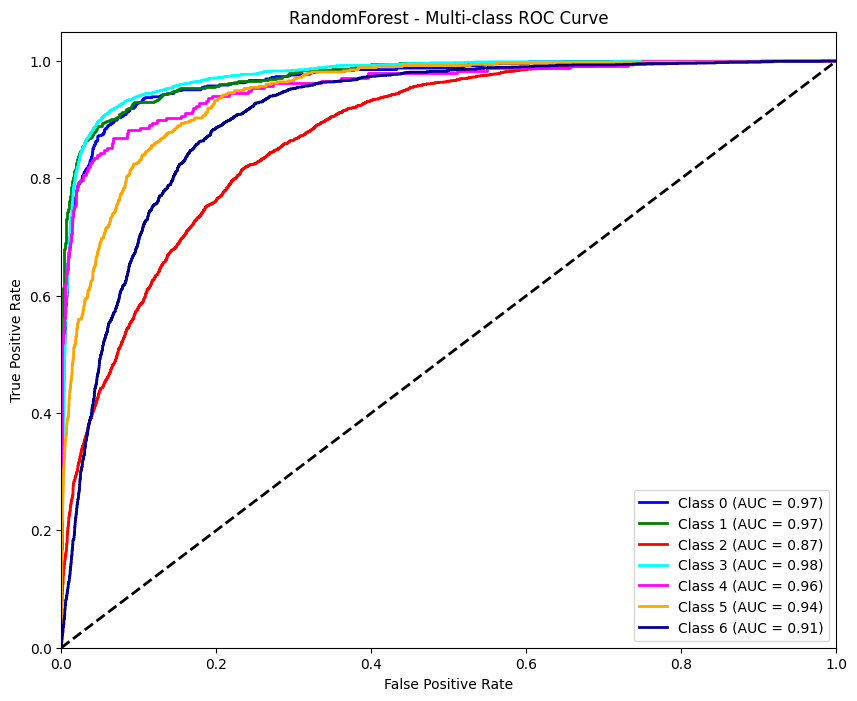

In [ ]:
evaluate_model_multiclass(RandomForest, X_test_1, y_test_1, model_name="RandomForest")


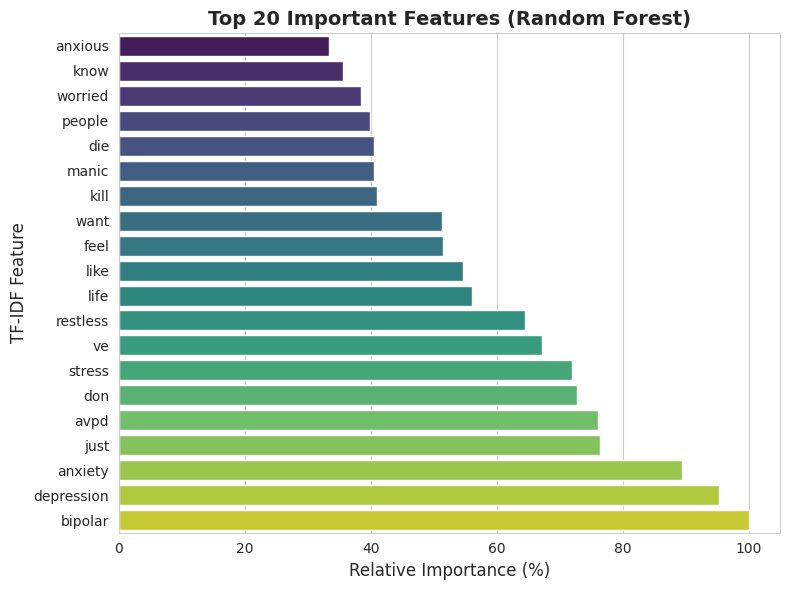

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the best_model is available after parameter tuning
if RandomForest is not None:
    # Get the feature names from TfidfVectorizer
    feature_names = tfidf.get_feature_names_out()

    # Get the feature importances from the trained Random Forest model
    feature_importance = RandomForest.feature_importances_
    feature_importance = (feature_importance / feature_importance.max()) * 100

    # Map feature importance to feature names
    important_features = sorted(
        zip(feature_importance, feature_names),
        key=lambda x: x[0],
        reverse=True
    )

    # Select top N features
    top_n = 20
    top_features = important_features[:top_n]
    importances, names = zip(*top_features)

    # Reverse for horizontal bar plot
    importances = importances[::-1]
    names = names[::-1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.barplot(x=importances, y=names, palette="viridis")

    plt.title("Top 20 Important Features (Random Forest)", fontsize=14, fontweight='bold')
    plt.xlabel("Relative Importance (%)", fontsize=12)
    plt.ylabel("TF-IDF Feature", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save high-res for paper
    plt.savefig("top_features_rf.png", dpi=300)
    plt.show()
else:
    print("No model was trained successfully. Unable to display feature importance.")


### 3.1.3 LGBM

In [ ]:
random.seed(1234)

# Parameter grid for LightGBM
param_grid = {
    'n_estimators': [100, 200],          # Number of boosting iterations
    'learning_rate': [0.01, 0.1, 0.2],       # Learning rate
    'num_leaves': [31, 63],              # Maximum number of leaves in a tree
    'max_depth': [None, 10],             # Maximum tree depth
    'class_weight': ['balanced', None],      # Handle class imbalance
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for n_estimators, learning_rate, num_leaves, max_depth, class_weight in product(
        param_grid['n_estimators'],
        param_grid['learning_rate'],
        param_grid['num_leaves'],
        param_grid['max_depth'],
        param_grid['class_weight']):
    try:
        # Create the LightGBM model with current parameters
        model = LGBMClassifier(
            objective='multiclass',                # Multi-class objective
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42,
            importance_type='gain'
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for n_estimators={n_estimators}, learning_rate={learning_rate}, num_leaves={num_leaves}, max_depth={max_depth}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'num_leaves': num_leaves,
                'max_depth': max_depth,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, learning_rate={learning_rate}, num_leaves={num_leaves}, max_depth={max_depth}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [23]:
LGBM = LGBMClassifier(
    objective='multiclass',                # Multi-class objective
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=63,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    importance_type='gain'
)

# Train the model
LGBM.fit(X_train_1, y_train_1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.413459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248244
[LightGBM] [Info] Number of data points in the train set: 31608, number of used features: 5192
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


LGBMClassifier(class_weight='balanced', importance_type='gain', max_depth=None,
               n_estimators=200, num_leaves=63, objective='multiclass',
               random_state=42)


--- Evaluation Report: LightGBM ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7947    0.8358    0.8147       755
           1     0.8809    0.8140    0.8462       527
           2     0.7158    0.7016    0.7086      3016
           3     0.9078    0.9202    0.9140      3308
           4     0.8750    0.5612    0.6838       237
           5     0.6331    0.5989    0.6155       536
           6     0.6613    0.7011    0.6806      2158

    accuracy                         0.7770     10537
   macro avg     0.7812    0.7333    0.7519     10537
weighted avg     0.7782    0.7770    0.7765     10537

Weighted F1 Score: 0.7767
95% CI for F1 Score: [0.7687, 0.7847]


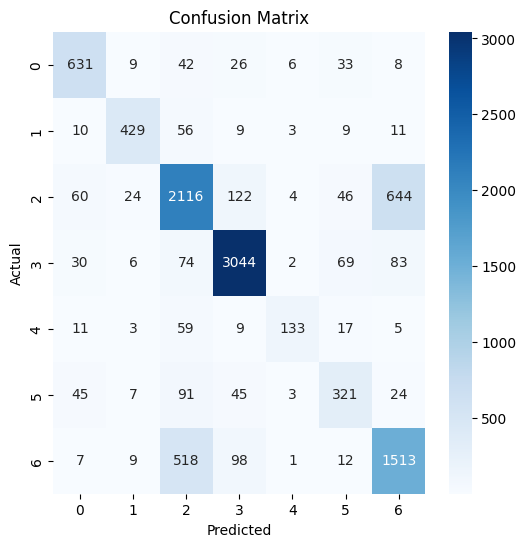

Macro-Averaged AUC: 0.9566
95% CI for AUC: [0.9534, 0.9594]


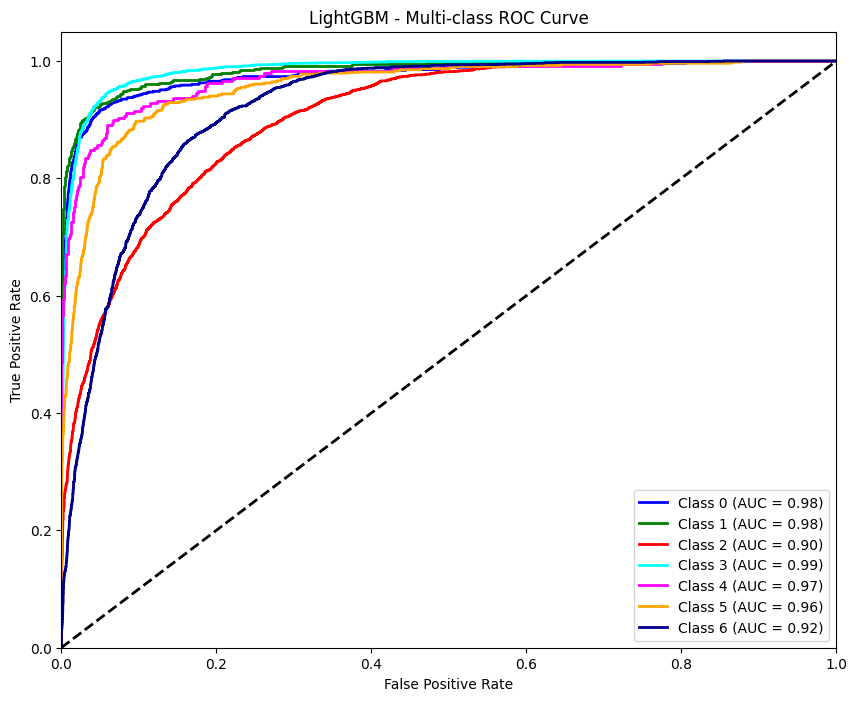

In [ ]:
evaluate_model_multiclass(LGBM, X_test_1, y_test_1, model_name="LightGBM")


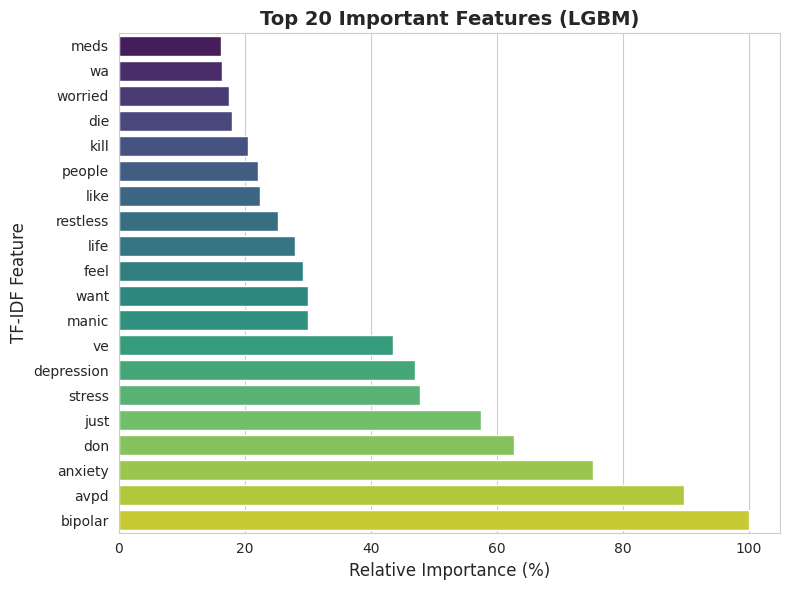

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the best_model is available after parameter tuning
if LGBM is not None:
    # Get the feature names from TfidfVectorizer
    feature_names = tfidf.get_feature_names_out()

    # Get the feature importances from the trained Random Forest model
    feature_importance = LGBM.feature_importances_
    feature_importance = (feature_importance / feature_importance.max()) * 100

    # Map feature importance to feature names
    important_features = sorted(
        zip(feature_importance, feature_names),
        key=lambda x: x[0],
        reverse=True
    )

    # Select top N features
    top_n = 20
    top_features = important_features[:top_n]
    importances, names = zip(*top_features)

    # Reverse for horizontal bar plot
    importances = importances[::-1]
    names = names[::-1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.barplot(x=importances, y=names, palette="viridis")

    plt.title("Top 20 Important Features (LGBM)", fontsize=14, fontweight='bold')
    plt.xlabel("Relative Importance (%)", fontsize=12)
    plt.ylabel("TF-IDF Feature", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save high-res for paper
    plt.savefig("top_features_lgbm.png", dpi=300)
    plt.show()
else:
    print("No model was trained successfully. Unable to display feature importance.")


## 3.2  DL Models


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
#from transformers.optimization  import AdamW
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from collections import Counter
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import numpy as np
import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install transformers --upgrade

### 3.2.1 Albert

In [ ]:
#make a copy especially for ALBERT
df2 = df.copy()

In [ ]:
# Pre-processing for ALBERT
def clean_text_Albert(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "<URL>", text)  # Replace URLs with <URL>
    text = re.sub(r"@\w+", "<USER>", text)   # Replace mentions with <USER>
    text = re.sub(r"#\w+", "<HASHTAG>", text)  # Replace hashtags with <HASHTAG>
    text = re.sub(r"[^\w\s]", "", text)      # Remove special characters
    text = re.sub(r"\s+", " ", text)         # Normalize whitespace
    return text.strip()

df2['statement'] = df2['statement'].apply(clean_text_Albert)


In [ ]:
# Initial train-test split: 60% train, 20% test, 20% validation
train_texts_2, test_texts_2, train_labels_2, test_labels_2 = train_test_split(
    df2['statement'].tolist(), df2['encoded_status'].tolist(), test_size=0.2, random_state=42
)
train_texts_2, val_texts_2, train_labels_2, val_labels_2 = train_test_split(
    train_texts_2, train_labels_2, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of original data
)


#Prepare the data for the model
# Load tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
max_len = 200

# Create Dataset objects
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)  # Ensure texts is a list of strings
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure each text is a string
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset_2 = SentimentDataset(train_texts_2, train_labels_2, tokenizer,max_len)
test_dataset_2 = SentimentDataset(test_texts_2, test_labels_2, tokenizer,max_len)
val_dataset_2 = SentimentDataset(val_texts_2,val_labels_2,tokenizer,max_len)


# Create DataLoaders
train_loader_2 = DataLoader(train_dataset_2, batch_size=4, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2,batch_size = 4)
test_loader_2 = DataLoader(test_dataset_2, batch_size=4)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
random.seed(1234)

def random_hyperparameter_tuning(train_texts, train_labels, val_texts, val_labels, tokenizer, n_iter=10):
    # Define hyperparameter ranges
    param_space = {
        'lr': (np.log10(1e-5), np.log10(1e-4)),              # Learning rate range
        'epochs': (3, 5),                # Epoch range
        'dropout': (0.1, 0.5)           # Dropout rate range
    }

    best_f1 = 0
    best_params = None
    best_model = None

    # Compute class weights for class imbalance
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Progress bar for random search iterations
    with tqdm(total=n_iter, desc="Random Search Tuning", leave=True) as pbar:
        for _ in range(n_iter):
            # Randomly sample hyperparameters
            hyperparams = {
                'lr': 10**np.random.uniform(*param_space['lr']),
                'epochs': np.random.randint(*param_space['epochs']),
                'dropout': np.random.uniform(*param_space['dropout'])
            }

            # Initialize model with dropout
            model = AlbertForSequenceClassification.from_pretrained(
                'albert-base-v2',
                num_labels=7,
                hidden_dropout_prob=hyperparams['dropout']
            ).to(device)

            optimizer = AdamW(model.parameters(), lr=hyperparams['lr'])
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

            # Training loop
            for epoch in range(hyperparams['epochs']):
                model.train()
                for batch in train_loader_2:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    optimizer.zero_grad()
                    outputs = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    loss.backward()
                    optimizer.step()

            # Validation evaluation
            model.eval()
            val_predictions, val_labels_batch = [], []
            with torch.no_grad():
                for batch in val_loader_2:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids, attention_mask=attention_mask)
                    preds = torch.argmax(outputs.logits, dim=1)
                    val_predictions.extend(preds.cpu().numpy())
                    val_labels_batch.extend(labels.cpu().numpy())

            # Calculate F1-score
            f1 = f1_score(val_labels_batch, val_predictions, average='weighted')
            accuracy = accuracy_score(val_labels_batch, val_predictions)

            # Update best model
            if f1 > best_f1:
                best_f1 = f1
                best_params = hyperparams
                best_model = model
                # Save the best model
                model_save_path = "best_albert_model.pth"
                torch.save(model.state_dict(), model_save_path)

            # Update progress bar
            pbar.set_postfix(f1=f1, accuracy=accuracy)
            pbar.update(1)

    print(f"Best F1 Score: {best_f1:.4f}")
    print(f"Best Hyperparameters: {best_params}")
    return best_params, best_f1, best_model

#Start timer
start_time = time.time()
best_params, best_f1, best_model = random_hyperparameter_tuning(
    train_texts=train_texts_2,
    train_labels=train_labels_2,
    val_texts=val_texts_2,
    val_labels=val_labels_2,
    tokenizer=tokenizer,
    n_iter=10
)
# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")


Random Search Tuning:   0%|          | 0/10 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Random Search Tuning:  10%|█         | 1/10 [39:24<5:54:42, 2364.74s/it, accuracy=0.312, f1=0.148]Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Random Search Tuning:  20%|██        | 2/10 [1:09:18<4:30:32, 2029.11s/it, accuracy=0.293, f1=0.133]Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model 

Best F1 Score: 0.7816
Best Hyperparameters: {'lr': 1.1668546806525978e-05, 'epochs': 4, 'dropout': 0.1532719106331748}
Total Parameter Tuning Time: 20860.15 seconds


In [ ]:
# Randomly sample hyperparameters
hyperparams = {
    'lr': 1.1668546806525978e-05,
    'epochs': 4,
    'dropout': 0.1532719106331748
}
train_texts=train_texts_2
train_labels=train_labels_2
val_texts=val_texts_2
val_labels=val_labels_2
# Compute class weights for class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# Initialize model with dropout
model = AlbertForSequenceClassification.from_pretrained(
    'albert-base-v2',
    num_labels=7,
    hidden_dropout_prob=hyperparams['dropout']
).to(device)

optimizer = AdamW(model.parameters(), lr=hyperparams['lr'])
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Training loop
for epoch in range(hyperparams['epochs']):
    model.train()
    for batch in train_loader_2:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Validation evaluation
model.eval()
val_predictions, val_labels_batch = [], []
with torch.no_grad():
    for batch in val_loader_2:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        val_predictions.extend(preds.cpu().numpy())
        val_labels_batch.extend(labels.cpu().numpy())

# Calculate F1-score
f1 = f1_score(val_labels_batch, val_predictions, average='weighted')
accuracy = accuracy_score(val_labels_batch, val_predictions)

In [ ]:
f1

0.7776142357705067

In [ ]:
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer with the same config as during training
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=7)
model.load_state_dict(torch.load("best_albert_model.pth", map_location=device))
model.to(device)

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# # Evaluation
# model.eval()
# test_predictions, test_labels_batch, test_probabilities = [], [], []

# with torch.no_grad():
#     for batch in test_loader_2:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['label'].to(device)

#         outputs = model(input_ids, attention_mask=attention_mask)
#         preds = torch.argmax(outputs.logits, dim=1)

#         test_predictions.extend(preds.cpu().numpy())
#         test_labels_batch.extend(labels.cpu().numpy())
#         probs = torch.softmax(outputs.logits, dim=1)[:, 1]
#         test_probabilities.extend(probs.cpu().numpy())

# # Metrics
# test_f1 = f1_score(test_labels_batch, test_predictions, average='weighted')
# test_accuracy = accuracy_score(test_labels_batch, test_predictions)

# print(f"Test F-1 Score: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def evaluate_pytorch_model(model, test_loader, device, model_name="DL Model", num_classes=7, use_attention_mask=True):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_auc_score, roc_curve, auc

    model.eval()
    model.to(device)

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            # Transformer: with attention mask
            if use_attention_mask:
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
            else:
                outputs = model(input_ids)

            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"\n--- Evaluation Report: {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    # F1 CI
    f1_scores = []
    for _ in range(1000):
        idx = resample(np.arange(len(all_labels)))
        if len(np.unique(all_labels[idx])) < 2:
            continue
        f1_bs = f1_score(all_labels[idx], all_preds[idx], average='weighted')
        f1_scores.append(f1_bs)
    print(f"95% CI for F1 Score: [{np.percentile(f1_scores, 2.5):.4f}, {np.percentile(f1_scores, 97.5):.4f}]")

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Multiclass ROC + AUC
    y_true_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    roc_auc_dict = {}
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_dict[i] = roc_auc
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Multiclass ROC Curve - {model_name}")
    plt.legend(loc='lower right')
    plt.show()

    # Bootstrapped AUC CI per class
    for i in range(num_classes):
        auc_scores = []
        for _ in range(1000):
            idx = resample(np.arange(len(all_labels)))
            if len(np.unique(y_true_bin[idx, i])) < 2:
                continue
            fpr_bs, tpr_bs, _ = roc_curve(y_true_bin[idx, i], all_probs[idx, i])
            auc_bs = auc(fpr_bs, tpr_bs)
            auc_scores.append(auc_bs)
        if auc_scores:
            print(f"Class {i} AUC: {roc_auc_dict[i]:.4f}")
            print(f"  95% CI: [{np.percentile(auc_scores, 2.5):.4f}, {np.percentile(auc_scores, 97.5):.4f}]")
        # Macro-averaged AUC and CI
    try:
        all_labels_onehot = label_binarize(all_labels, classes=np.arange(num_classes))

        macro_auc = roc_auc_score(all_labels_onehot, all_probs, average='macro')

        # Bootstrap macro AUC
        macro_auc_scores = []
        for _ in range(1000):
            idx = resample(np.arange(len(all_labels)))
            y_true_bs = all_labels_onehot[idx]
            y_prob_bs = all_probs[idx]
            try:
                auc_bs = roc_auc_score(y_true_bs, y_prob_bs, average='macro')
                macro_auc_scores.append(auc_bs)
            except ValueError:
                continue

        macro_ci_low = np.percentile(macro_auc_scores, 2.5)
        macro_ci_high = np.percentile(macro_auc_scores, 97.5)

        print(f"\nMacro-Averaged AUC: {macro_auc:.4f}")
        print(f"95% CI for Macro-Averaged AUC: [{macro_ci_low:.4f}, {macro_ci_high:.4f}]")
    except ValueError as e:
        print(f"Could not compute macro-averaged AUC: {e}")




--- Evaluation Report: ALBERT ---
Accuracy: 0.7839
Weighted F1 Score: 0.7917
95% CI for F1 Score: [0.7842, 0.7992]


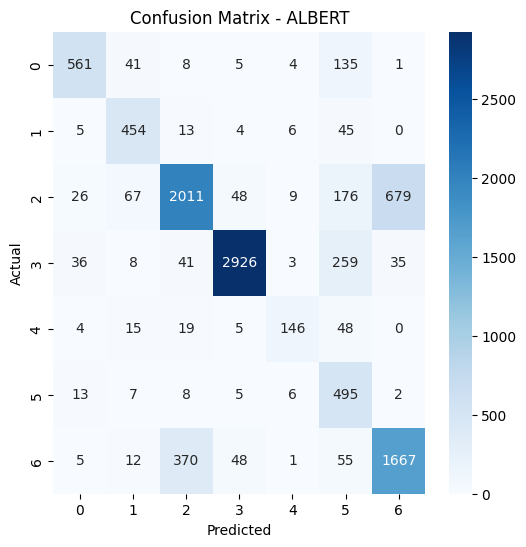

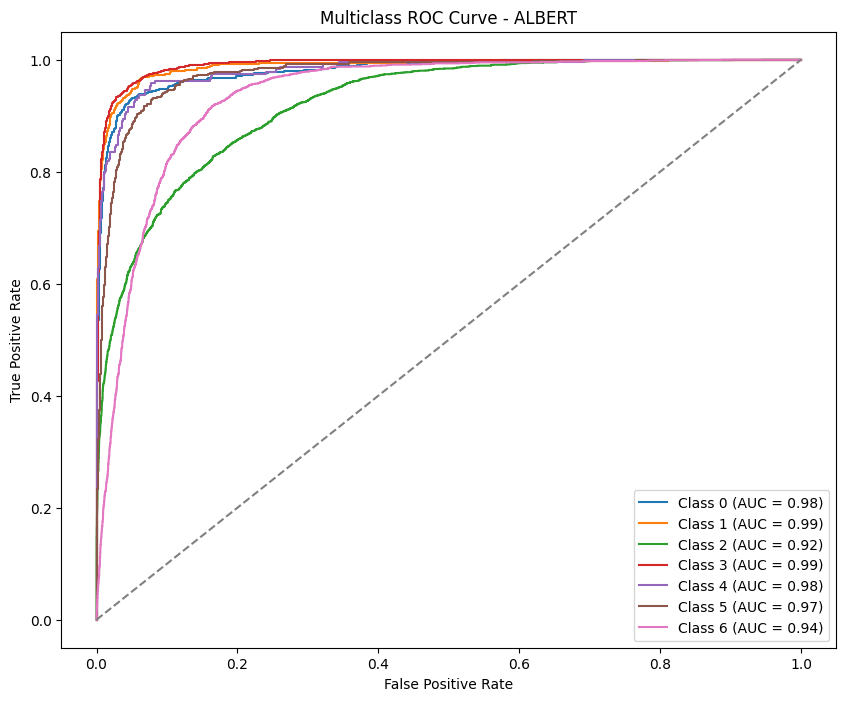

Class 0 AUC: 0.9806
  95% CI: [0.9757, 0.9849]
Class 1 AUC: 0.9882
  95% CI: [0.9831, 0.9921]
Class 2 AUC: 0.9211
  95% CI: [0.9163, 0.9264]
Class 3 AUC: 0.9911
  95% CI: [0.9897, 0.9922]
Class 4 AUC: 0.9812
  95% CI: [0.9722, 0.9884]
Class 5 AUC: 0.9750
  95% CI: [0.9696, 0.9801]
Class 6 AUC: 0.9360
  95% CI: [0.9313, 0.9404]

Macro-Averaged AUC: 0.9676
95% CI for Macro-Averaged AUC: [0.9655, 0.9698]


In [ ]:
evaluate_pytorch_model(model, test_loader_2, device, model_name="ALBERT", num_classes=7, use_attention_mask=True)

In [ ]:
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer with the same config as during training
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=7)
model.load_state_dict(torch.load("best_albert_model.pth", map_location=device))
model.to(device)

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Evaluation
model.eval()
test_predictions, test_labels_batch, test_probabilities = [], [], []

with torch.no_grad():
    for batch in test_loader_2:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        test_predictions.extend(preds.cpu().numpy())
        test_labels_batch.extend(labels.cpu().numpy())
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        test_probabilities.extend(probs.cpu().numpy())
albert = model


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2.2 GRU

In [ ]:
#copy for GRU
df3 = df.copy()

In [ ]:
# Pre-processing for GRU - still minimal
def clean_text_GRU(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "<URL>", text)  # Replace URLs
    text = re.sub(r"@\w+", "<USER>", text)   # Replace mentions
    text = re.sub(r"#\w+", "<HASHTAG>", text)  # Replace hashtags
    text = re.sub(r"[^\w\s]", "", text)      # Remove special characters
    text = re.sub(r"\s+", " ", text)         # Normalize whitespace
    return text.strip()

df3['statement'] = df3['statement'].apply(clean_text_GRU)

In [ ]:
# Hyperparameters
MAX_LEN = 200  # Maximum sequence length
VOCAB_SIZE = 10000  # Vocabulary size
BATCH_SIZE = 16

# Split Dataset
# Initial train-test split
train_texts_3, test_texts_3, train_labels_3, test_labels_3 = train_test_split(
    df3['statement'].tolist(), df3['encoded_status'].tolist(), test_size=0.2, random_state=42
)
# Further split training data into training and validation sets
train_texts_3, val_texts_3, train_labels_3, val_labels_3 = train_test_split(
    train_texts_3, train_labels_3, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of original data
)

# **MODIFIED**: Build Vocabulary after the train-validation-test split
# Build Vocabulary on Training Data Only
all_train_words = " ".join(train_texts_3).split()
most_common_words = [word for word, _ in Counter(all_train_words).most_common(VOCAB_SIZE - 1)]
word_to_index = {word: idx + 1 for idx, word in enumerate(most_common_words)}

# Text-to-Sequence Conversion
def text_to_sequence(text, word_to_index, max_len=MAX_LEN):
    tokens = text.split()
    sequence = [word_to_index.get(word, 0) for word in tokens]
    return sequence[:max_len]

# Convert text to sequences for train, validation, and test sets
train_sequences_3 = [text_to_sequence(text, word_to_index) for text in train_texts_3]
val_sequences_3 = [text_to_sequence(text, word_to_index) for text in val_texts_3]
test_sequences_3 = [text_to_sequence(text, word_to_index) for text in test_texts_3]

# Pad Sequences
train_sequences_3 = nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in train_sequences_3], batch_first=True, padding_value=0)
val_sequences_3 = nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in val_sequences_3], batch_first=True, padding_value=0)
test_sequences_3 = nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in test_sequences_3], batch_first=True, padding_value=0)

# Convert Labels
train_labels_3 = torch.tensor(train_labels_3, dtype=torch.long)
val_labels_3 = torch.tensor(val_labels_3, dtype=torch.long)
test_labels_3 = torch.tensor(test_labels_3, dtype=torch.long)

# Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.texts[idx],
            'label': self.labels[idx]
        }

# Create Datasets and DataLoaders
train_dataset_3 = SentimentDataset(train_sequences_3, train_labels_3)
val_dataset_3 = SentimentDataset(val_sequences_3, val_labels_3)
test_dataset_3 = SentimentDataset(test_sequences_3, test_labels_3)

train_loader_3 = DataLoader(train_dataset_3, batch_size=BATCH_SIZE, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=BATCH_SIZE)
test_loader_3 = DataLoader(test_dataset_3, batch_size=BATCH_SIZE)

In [ ]:
# Define GRU Model
class GRUSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRUSentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, hidden = self.gru(embedded)  # Only last hidden state
        output = self.fc(self.dropout(hidden[-1]))
        return output  # **MODIFIED**: Removed `softmax` because `CrossEntropyLoss` expects raw logits

# #Define Loss Function
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.2, gamma=0.5, ignore_index=-1):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.ignore_index = ignore_index
#         self.cross_entropy = nn.CrossEntropyLoss(ignore_index=ignore_index, reduction='none')

#     def forward(self, logits, target):
#         # Cross entropy loss
#         ce_loss = self.cross_entropy(logits, target)
#         # Probabilities of correct class
#         pt = torch.exp(-ce_loss)
#         # Focal loss
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
#         return focal_loss.mean()


In [ ]:
random.seed(1234)

def train_and_evaluate(hyperparams, train_loader, val_loader, vocab_size, output_dim, device):
    embedding_dim = int(hyperparams['embedding_dim'])
    hidden_dim = int(hyperparams['hidden_dim'])
    lr = hyperparams['lr']
    # alpha = hyperparams['alpha']
    # gamma = hyperparams['gamma']

    # Initialize the model, loss, and optimizer
    model = GRUSentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

    # **MODIFIED**: Compute class weights for the training set
    all_train_labels = [label for batch in train_loader for label in batch['label'].numpy()]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(all_train_labels),
        y=all_train_labels
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)  # Convert to PyTorch tensor

    # **MODIFIED**: Use CrossEntropyLoss with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(hyperparams['epochs']):
        model.train()
        total_loss = 0
        train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{hyperparams['epochs']}", leave=True, position=0)
        for batch in train_loop:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)  # **MODIFIED**: Use CrossEntropyLoss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            train_loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}/{hyperparams['epochs']}, Loss: {total_loss / len(train_loader):.4f}")

    # Validation evaluation
    model.eval()
    val_predictions, val_labels = [], []
    val_loop = tqdm(val_loader, desc="Validating", leave=True, position=0)
    with torch.no_grad():
        for batch in val_loop:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate F1 score and accuracy
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    accuracy = accuracy_score(val_labels, val_predictions)
    print(f"Validation F-1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    return f1, accuracy, model


def random_hyperparameter_tuning(train_loader, val_loader, vocab_size, output_dim, device, n_iter=20):
    # Define hyperparameter ranges for random search
    param_space = {
        'embedding_dim': (150, 250),
        'hidden_dim': (256, 768),
        'lr': (np.log10(1e-4), np.log10(1e-3)),  # Log-uniform for learning rate
        'epochs': (5, 10),  # **MODIFIED**: Removed `alpha` and `gamma` since FocalLoss is no longer used
    }

    best_f1 = 0
    best_params = None
    best_model = None

    # Random search iterations
    with tqdm(total=n_iter, desc="Random Search Tuning", leave=True, position=0) as pbar:
        for _ in range(n_iter):
            # Sample hyperparameters
            hyperparams = {
                'embedding_dim': np.random.uniform(*param_space['embedding_dim']),
                'hidden_dim': np.random.uniform(*param_space['hidden_dim']),
                'lr': 10**np.random.uniform(*param_space['lr']),
                'epochs': np.random.randint(*param_space['epochs']),
            }
            f1, accuracy, model = train_and_evaluate(hyperparams, train_loader, val_loader, vocab_size, output_dim, device)
            pbar.set_postfix(f1=f1, accuracy=accuracy)
            pbar.update(1)

            if f1 > best_f1:
                best_f1 = f1
                best_params = hyperparams
                best_model = model

    print(f"Best Validation F1 Score: {best_f1:.4f}")
    print(f"Best Hyperparameters: {best_params}")

    # Save the best model
    torch.save(best_model.state_dict(), "best_gru_model.pth")
    return best_params, best_f1, best_model

#Start timer
start_time = time.time()
# Run random search
best_params, best_f1, best_model= random_hyperparameter_tuning(
    train_loader_3,
    val_loader_3,
    vocab_size=VOCAB_SIZE,
    output_dim=7,
    device=device,
    n_iter=10  # Number of random samples to evaluate
)
# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")


Training Epoch 1/8: 100%|██████████| 1976/1976 [00:20<00:00, 94.67it/s, loss=0.791] 


Epoch 1/8, Loss: 1.6896


Training Epoch 2/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.97it/s, loss=1.25]


Epoch 2/8, Loss: 1.2287


Training Epoch 3/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.88it/s, loss=0.897]


Epoch 3/8, Loss: 0.9653


Training Epoch 4/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.57it/s, loss=2.4]


Epoch 4/8, Loss: 0.7063


Training Epoch 5/8: 100%|██████████| 1976/1976 [00:19<00:00, 103.56it/s, loss=1.02]


Epoch 5/8, Loss: 0.5615


Training Epoch 6/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.60it/s, loss=0.0708]


Epoch 6/8, Loss: 0.4555


Training Epoch 7/8: 100%|██████████| 1976/1976 [00:19<00:00, 103.09it/s, loss=0.445]


Epoch 7/8, Loss: 0.3733


Training Epoch 8/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.79it/s, loss=0.475]


Epoch 8/8, Loss: 0.3059


Random Search Tuning:  10%|█         | 1/10 [02:38<23:44, 158.23s/it, accuracy=0.766, f1=0.77]

Validation F-1 Score: 0.7697, Accuracy: 0.7659


Training Epoch 1/6: 100%|██████████| 1976/1976 [00:26<00:00, 74.07it/s, loss=1.22]


Epoch 1/6, Loss: 1.5322


Training Epoch 2/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.90it/s, loss=0.959]


Epoch 2/6, Loss: 0.8890


Training Epoch 3/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.93it/s, loss=0.897]


Epoch 3/6, Loss: 0.6092


Training Epoch 4/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.83it/s, loss=0.129]


Epoch 4/6, Loss: 0.4394


Training Epoch 5/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.93it/s, loss=0.18]


Epoch 5/6, Loss: 0.3118


Training Epoch 6/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.98it/s, loss=0.126]


Epoch 6/6, Loss: 0.2192


Random Search Tuning:  20%|██        | 2/10 [05:22<21:33, 161.74s/it, accuracy=0.776, f1=0.78]

Validation F-1 Score: 0.7796, Accuracy: 0.7759


Training Epoch 1/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.37it/s, loss=1.54]


Epoch 1/7, Loss: 1.8098


Training Epoch 2/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.67it/s, loss=0.859]


Epoch 2/7, Loss: 1.4336


Training Epoch 3/7: 100%|██████████| 1976/1976 [00:18<00:00, 104.04it/s, loss=2.47]


Epoch 3/7, Loss: 1.2286


Training Epoch 4/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.57it/s, loss=1.14]


Epoch 4/7, Loss: 1.1090


Training Epoch 5/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.24it/s, loss=1.05]


Epoch 5/7, Loss: 0.9588


Training Epoch 6/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.80it/s, loss=0.866]


Epoch 6/7, Loss: 0.8263


Training Epoch 7/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.62it/s, loss=1]


Epoch 7/7, Loss: 0.7041


Random Search Tuning:  30%|███       | 3/10 [07:38<17:30, 150.04s/it, accuracy=0.711, f1=0.715]

Validation F-1 Score: 0.7155, Accuracy: 0.7106


Training Epoch 1/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.03it/s, loss=2.74]


Epoch 1/7, Loss: 1.7805


Training Epoch 2/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.38it/s, loss=1.3]


Epoch 2/7, Loss: 1.4320


Training Epoch 3/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.37it/s, loss=1.51]


Epoch 3/7, Loss: 1.2367


Training Epoch 4/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.56it/s, loss=0.861]


Epoch 4/7, Loss: 1.1093


Training Epoch 5/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.62it/s, loss=0.471]


Epoch 5/7, Loss: 0.9145


Training Epoch 6/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.39it/s, loss=0.469]


Epoch 6/7, Loss: 0.7365


Training Epoch 7/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.17it/s, loss=0.692]


Epoch 7/7, Loss: 0.6272


Random Search Tuning:  40%|████      | 4/10 [10:11<15:06, 151.13s/it, accuracy=0.726, f1=0.728]

Validation F-1 Score: 0.7282, Accuracy: 0.7262


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.40it/s, loss=0.849]


Epoch 1/9, Loss: 1.2165


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.45it/s, loss=1.08]


Epoch 2/9, Loss: 0.6593


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:21<00:00, 91.03it/s, loss=0.41]


Epoch 3/9, Loss: 0.4325


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.77it/s, loss=0.174]


Epoch 4/9, Loss: 0.2936


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.91it/s, loss=0.268]


Epoch 5/9, Loss: 0.2096


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.75it/s, loss=0.179]


Epoch 6/9, Loss: 0.1627


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.38it/s, loss=0.074]


Epoch 7/9, Loss: 0.1447


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.50it/s, loss=0.173]


Epoch 8/9, Loss: 0.1305


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.40it/s, loss=0.0904]


Epoch 9/9, Loss: 0.1132


Random Search Tuning:  50%|█████     | 5/10 [13:30<14:02, 168.50s/it, accuracy=0.764, f1=0.766]

Validation F-1 Score: 0.7663, Accuracy: 0.7641


Training Epoch 1/6: 100%|██████████| 1976/1976 [00:18<00:00, 108.02it/s, loss=1.6]


Epoch 1/6, Loss: 1.4366


Training Epoch 2/6: 100%|██████████| 1976/1976 [00:18<00:00, 109.02it/s, loss=0.551]


Epoch 2/6, Loss: 0.7683


Training Epoch 3/6: 100%|██████████| 1976/1976 [00:18<00:00, 108.63it/s, loss=0.266]


Epoch 3/6, Loss: 0.5327


Training Epoch 4/6: 100%|██████████| 1976/1976 [00:18<00:00, 108.24it/s, loss=0.207]


Epoch 4/6, Loss: 0.3669


Training Epoch 5/6: 100%|██████████| 1976/1976 [00:18<00:00, 108.86it/s, loss=0.148]


Epoch 5/6, Loss: 0.2623


Training Epoch 6/6: 100%|██████████| 1976/1976 [00:18<00:00, 109.07it/s, loss=0.043]


Epoch 6/6, Loss: 0.1968


Random Search Tuning:  60%|██████    | 6/10 [15:22<09:56, 149.09s/it, accuracy=0.76, f1=0.764]

Validation F-1 Score: 0.7642, Accuracy: 0.7600


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:20<00:00, 94.40it/s, loss=0.233]


Epoch 1/9, Loss: 1.2384


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:20<00:00, 94.69it/s, loss=1.1]


Epoch 2/9, Loss: 0.6694


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.16it/s, loss=2.22]


Epoch 3/9, Loss: 0.4330


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.20it/s, loss=0.196]


Epoch 4/9, Loss: 0.2824


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.46it/s, loss=0.149]


Epoch 5/9, Loss: 0.2170


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.18it/s, loss=0.285]


Epoch 6/9, Loss: 0.1659


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.13it/s, loss=0.545]


Epoch 7/9, Loss: 0.1418


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.70it/s, loss=0.0806]


Epoch 8/9, Loss: 0.1046


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.36it/s, loss=0.0031]


Epoch 9/9, Loss: 0.1074


Random Search Tuning:  70%|███████   | 7/10 [18:31<08:07, 162.41s/it, accuracy=0.772, f1=0.77]

Validation F-1 Score: 0.7695, Accuracy: 0.7717


Training Epoch 1/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.25it/s, loss=0.855]


Epoch 1/8, Loss: 1.5821


Training Epoch 2/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.43it/s, loss=0.819] 


Epoch 2/8, Loss: 1.0667


Training Epoch 3/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.39it/s, loss=0.451]


Epoch 3/8, Loss: 0.7212


Training Epoch 4/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.06it/s, loss=1.21]


Epoch 4/8, Loss: 0.5464


Training Epoch 5/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.77it/s, loss=0.339]


Epoch 5/8, Loss: 0.4140


Training Epoch 6/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.33it/s, loss=0.217]


Epoch 6/8, Loss: 0.3052


Training Epoch 7/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.09it/s, loss=0.788]


Epoch 7/8, Loss: 0.2486


Training Epoch 8/8: 100%|██████████| 1976/1976 [00:20<00:00, 97.84it/s, loss=0.487]


Epoch 8/8, Loss: 0.2028


Random Search Tuning:  80%|████████  | 8/10 [21:13<05:24, 162.24s/it, accuracy=0.777, f1=0.778]

Validation F-1 Score: 0.7782, Accuracy: 0.7769


Training Epoch 1/6: 100%|██████████| 1976/1976 [00:19<00:00, 99.94it/s, loss=1.65] 


Epoch 1/6, Loss: 1.6916


Training Epoch 2/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.26it/s, loss=0.964]


Epoch 2/6, Loss: 1.2137


Training Epoch 3/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.19it/s, loss=0.696]


Epoch 3/6, Loss: 0.8946


Training Epoch 4/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.44it/s, loss=0.225]


Epoch 4/6, Loss: 0.6601


Training Epoch 5/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.45it/s, loss=0.189]


Epoch 5/6, Loss: 0.5230


Training Epoch 6/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.47it/s, loss=0.182]


Epoch 6/6, Loss: 0.4109


Random Search Tuning:  90%|█████████ | 9/10 [23:14<02:29, 149.31s/it, accuracy=0.754, f1=0.758]

Validation F-1 Score: 0.7579, Accuracy: 0.7539


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.44it/s, loss=1.05]


Epoch 1/9, Loss: 1.2652


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.40it/s, loss=0.422]


Epoch 2/9, Loss: 0.6715


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.44it/s, loss=0.592]


Epoch 3/9, Loss: 0.4501


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.45it/s, loss=0.601]


Epoch 4/9, Loss: 0.3020


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.80it/s, loss=0.117]


Epoch 5/9, Loss: 0.2201


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.51it/s, loss=0.207]


Epoch 6/9, Loss: 0.1883


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:18<00:00, 105.23it/s, loss=0.0495]


Epoch 7/9, Loss: 0.1551


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.09it/s, loss=0.154]


Epoch 8/9, Loss: 0.1269


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.22it/s, loss=0.03]


Epoch 9/9, Loss: 0.1186


Random Search Tuning: 100%|██████████| 10/10 [26:07<00:00, 156.72s/it, accuracy=0.766, f1=0.768]

Validation F-1 Score: 0.7676, Accuracy: 0.7661
Best Validation F1 Score: 0.7796
Best Hyperparameters: {'embedding_dim': 236.21551351942213, 'hidden_dim': 730.8954918537037, 'lr': 0.0002984445605274827, 'epochs': 6}
Total Parameter Tuning Time: 1567.24 seconds


In [ ]:
train_loader = train_loader_3
val_loader = val_loader_3
vocab_size=VOCAB_SIZE
output_dim=7
hyperparams = {'embedding_dim': 236.21551351942213, 'hidden_dim': 730.8954918537037, 'lr': 0.0002984445605274827, 'epochs': 6}
embedding_dim = int(hyperparams['embedding_dim'])
hidden_dim = int(hyperparams['hidden_dim'])
lr = hyperparams['lr']
# alpha = hyperparams['alpha']
# gamma = hyperparams['gamma']

# Initialize the model, loss, and optimizer
model = GRUSentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

# **MODIFIED**: Compute class weights for the training set
all_train_labels = [label for batch in train_loader for label in batch['label'].numpy()]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_train_labels),
    y=all_train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)  # Convert to PyTorch tensor

# **MODIFIED**: Use CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(hyperparams['epochs']):
    model.train()
    total_loss = 0
    train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{hyperparams['epochs']}", leave=True, position=0)
    for batch in train_loop:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)  # **MODIFIED**: Use CrossEntropyLoss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1}/{hyperparams['epochs']}, Loss: {total_loss / len(train_loader):.4f}")

gru = model

Training Epoch 1/6: 100%|██████████| 1976/1976 [01:11<00:00, 27.53it/s, loss=1.04]


Epoch 1/6, Loss: 1.5243


Training Epoch 2/6: 100%|██████████| 1976/1976 [01:11<00:00, 27.77it/s, loss=0.415]


Epoch 2/6, Loss: 0.8724


Training Epoch 3/6: 100%|██████████| 1976/1976 [01:11<00:00, 27.70it/s, loss=0.385]


Epoch 3/6, Loss: 0.6153


Training Epoch 4/6: 100%|██████████| 1976/1976 [01:11<00:00, 27.66it/s, loss=1.35]


Epoch 4/6, Loss: 0.4418


Training Epoch 5/6: 100%|██████████| 1976/1976 [01:11<00:00, 27.75it/s, loss=0.121]


Epoch 5/6, Loss: 0.3090


Training Epoch 6/6: 100%|██████████| 1976/1976 [01:11<00:00, 27.80it/s, loss=0.0507]

Epoch 6/6, Loss: 0.2353


In [ ]:
gru

GRUSentimentModel(
  (embedding): Embedding(10000, 236)
  (gru): GRU(236, 730, batch_first=True)
  (fc): Linear(in_features=730, out_features=7, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


--- Evaluation Report: GRU ---
Accuracy: 0.7740
Weighted F1 Score: 0.7750
95% CI for F1 Score: [0.7663, 0.7830]


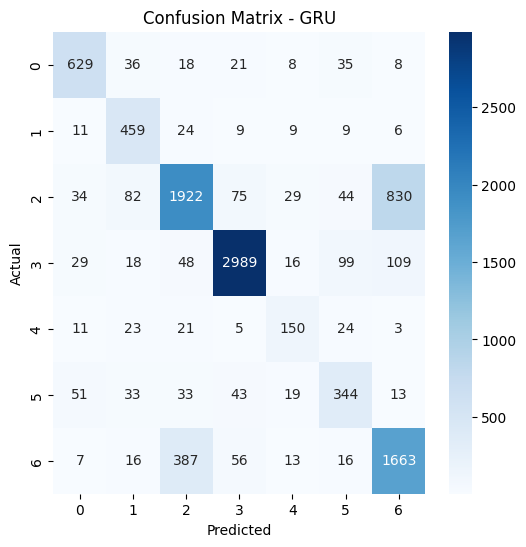

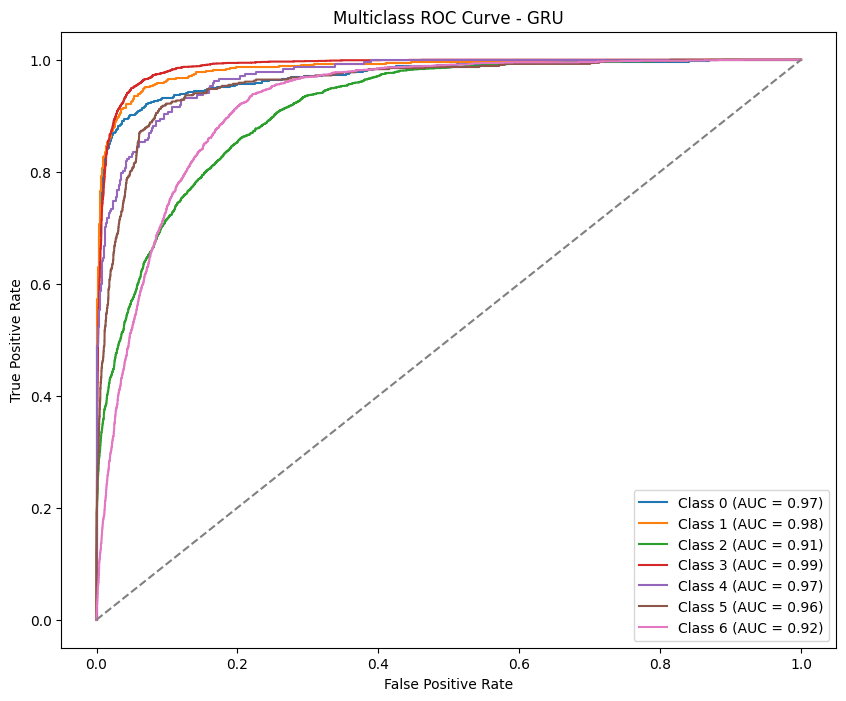

Class 0 AUC: 0.9725
  95% CI: [0.9652, 0.9794]
Class 1 AUC: 0.9842
  95% CI: [0.9782, 0.9890]
Class 2 AUC: 0.9147
  95% CI: [0.9094, 0.9201]
Class 3 AUC: 0.9884
  95% CI: [0.9869, 0.9899]
Class 4 AUC: 0.9708
  95% CI: [0.9626, 0.9784]
Class 5 AUC: 0.9595
  95% CI: [0.9515, 0.9673]
Class 6 AUC: 0.9217
  95% CI: [0.9163, 0.9267]

Macro-Averaged AUC: 0.9588
95% CI for Macro-Averaged AUC: [0.9560, 0.9615]


In [ ]:
evaluate_pytorch_model(gru, test_loader_3, device, model_name="GRU", num_classes=7, use_attention_mask=False)

In [ ]:
# Evaluate the best model on the test set
best_model = gru
best_model.eval()
test_predictions_gru, test_labels_gru = [], []
test_probabilities = []
# **MODIFIED**: Added probabilities collection for further analysis if needed

with torch.no_grad():
    for batch in test_loader_3:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = best_model(input_ids)

        # Apply softmax to get probabilities for all classes
        probs = torch.softmax(outputs, dim=1)
        test_probabilities.extend(probs.cpu().numpy())  # Collect probabilities for all classes

        # Collect predictions and labels (unchanged)
        preds = torch.argmax(probs, dim=1)
        test_predictions_gru.extend(preds.cpu().numpy())
        test_labels_gru.extend(labels.cpu().numpy())


In [ ]:
from scipy.stats import wilcoxon
import numpy as np
from itertools import combinations
import pandas as pd

def run_wilcoxon_test_multiclass(y_true, model_preds, method='bonferroni'):
    """
    Perform pairwise Wilcoxon signed-rank test for all model combinations for multiclass classification.

    Parameters:
        y_true (np.ndarray): True labels
        model_preds (dict): Dictionary with model names as keys and model predictions (probabilities or hard predictions) as values
        method (str): p-value correction method (e.g., 'holm', 'bonferroni')

    Returns:
        pd.DataFrame: Results table
    """
    assert all(len(y_true) == len(preds) for preds in model_preds.values()), "All predictions must match y_true length."

    results = []
    model_names = list(model_preds.keys())

    # Run pairwise Wilcoxon tests for all model pairs
    for m1, m2 in combinations(model_names, 2):
        y_pred_1, y_pred_2 = model_preds[m1], model_preds[m2]

        # For multiclass, we will use the predicted probabilities (if available)
        if y_pred_1.ndim == 2:  # If using probability outputs
            stat, p_value = wilcoxon(y_pred_1.max(axis=1), y_pred_2.max(axis=1))
        else:  # If using hard predictions
            stat, p_value = wilcoxon(y_pred_1, y_pred_2)

        # Store results
        results.append({
            "Model 1": m1,
            "Model 2": m2,
            "Statistic": stat,
            "p-value": p_value,
            "Winner": m1 if stat < 0 else m2  # Decide winner based on the statistic sign
        })

    # Correct for multiple testing
    raw_pvals = [r["p-value"] for r in results]
    from statsmodels.stats.multitest import multipletests
    _, corrected_pvals, _, _ = multipletests(raw_pvals, method=method)

    for i, p_corr in enumerate(corrected_pvals):
        results[i]["Corrected p-value"] = p_corr
        results[i]["Significant"] = "Yes" if p_corr < 0.05 else "No"

    # Print results in a DataFrame
    df_results = pd.DataFrame(results)
    print("\n📊 Pairwise Wilcoxon Signed-Rank Test Results (corrected using '{}'):\n".format(method))
    print(df_results[["Model 1", "Model 2", "Winner", "Statistic", "Corrected p-value", "Significant"]])

    return df_results




In [ ]:
SVM_preds = SVM.predict(X_test_1)
LGBM_preds = LGBM.predict(X_test_1)
RandomForest_preds = RandomForest.predict(X_test_1)
LR_preds = LR.predict(X_test_1)



In [ ]:
from scipy.stats import wilcoxon
import numpy as np
from itertools import combinations
import pandas as pd
from statsmodels.stats.multitest import multipletests

def run_wilcoxon_test_multiclass(y_true, model_preds, method='bonferroni'):
    """
    Perform pairwise Wilcoxon signed-rank test for all model combinations for multiclass classification.

    Parameters:
        y_true (np.ndarray): True labels
        model_preds (dict): Dictionary with model names as keys and model predictions
                            (either probabilities [n_samples, n_classes] or hard predictions [n_samples]) as values
        method (str): p-value correction method (e.g., 'holm', 'bonferroni')

    Returns:
        pd.DataFrame: Results table
    """
    assert all(len(y_true) == len(preds) for preds in model_preds.values()), "All predictions must match y_true length."

    results = []
    model_names = list(model_preds.keys())

    for m1, m2 in combinations(model_names, 2):
        y_pred_1, y_pred_2 = model_preds[m1], model_preds[m2]

        try:
            if y_pred_1.ndim == 2:  # Assume probabilities
                score_1 = y_pred_1.max(axis=1)
                score_2 = y_pred_2.max(axis=1)
            else:  # Hard predictions
                score_1 = y_pred_1
                score_2 = y_pred_2

            stat, p_value = wilcoxon(score_1, score_2)

        except ValueError as e:
            # Handle ties or zero differences which Wilcoxon doesn't support well
            stat, p_value = np.nan, 1.0

        # Determine "winner" logic conservatively
        if p_value >= 0.05:
            winner = "Inconclusive"
        elif stat > 0:
            winner = f"{m2} > {m1}"
        else:
            winner = f"{m1} > {m2}"

        results.append({
            "Model 1": m1,
            "Model 2": m2,
            "Statistic": stat,
            "Raw p-value": p_value,
            "Winner": winner
        })

    # Correct p-values for multiple comparisons
    raw_pvals = [r["Raw p-value"] for r in results]
    _, corrected_pvals, _, _ = multipletests(raw_pvals, method=method)

    for i, p_corr in enumerate(corrected_pvals):
        results[i]["Corrected p-value"] = p_corr
        results[i]["Significant"] = "Yes" if p_corr < 0.05 else "No"

    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    print("\n📊 Pairwise Wilcoxon Signed-Rank Test Results (corrected using '{}'):\n".format(method))
    print(df_results[["Model 1", "Model 2", "Winner", "Statistic", "Raw p-value", "Corrected p-value", "Significant"]])

    return df_results


In [ ]:
# Assume you have predictions from multiple models
model_preds = {
    "SVM": SVM_preds,  # Use predicted probabilities or hard predictions
    "LGBM": LGBM_preds,
    "RandomForest": RandomForest_preds,
    "LR": LR_preds,
    "ALBERT": np.array(test_predictions),
    "GRU": np.array(test_predictions_gru),
}

# y_test_1 is the ground truth
run_wilcoxon_test_multiclass(y_test_1, model_preds)


📊 Pairwise Wilcoxon Signed-Rank Test Results (corrected using 'bonferroni'):

         Model 1       Model 2                 Winner  Statistic  \
0            SVM          LGBM             LGBM > SVM   449855.5   
1            SVM  RandomForest     RandomForest > SVM   665111.5   
2            SVM            LR               LR > SVM   237637.5   
3            SVM        ALBERT           ALBERT > SVM   884247.5   
4            SVM           GRU              GRU > SVM   982494.5   
5           LGBM  RandomForest           Inconclusive   729925.0   
6           LGBM            LR              LR > LGBM   719701.0   
7           LGBM        ALBERT          ALBERT > LGBM   908473.5   
8           LGBM           GRU             GRU > LGBM  1082406.0   
9   RandomForest            LR      LR > RandomForest  1170186.5   
10  RandomForest        ALBERT  ALBERT > RandomForest  1041079.0   
11  RandomForest           GRU     GRU > RandomForest  1213973.5   
12            LR        ALBERT       

,Model 1,Model 2,Statistic,Raw p-value,Winner,Corrected p-value,Significant
0,SVM,LGBM,449855.5,9.448231e-27,LGBM > SVM,1.417235e-25,Yes
1,SVM,RandomForest,665111.5,3.814481e-27,RandomForest > SVM,5.721721e-26,Yes
2,SVM,LR,237637.5,3.872553e-10,LR > SVM,5.808829e-09,Yes
3,SVM,ALBERT,884247.5,1.615258e-119,ALBERT > SVM,2.422886e-118,Yes
4,SVM,GRU,982494.5,4.623847e-71,GRU > SVM,6.935771e-70,Yes
5,LGBM,RandomForest,729925.0,1.841692e-01,Inconclusive,1.000000e+00,No
6,LGBM,LR,719701.0,8.308678e-07,LR > LGBM,1.246302e-05,Yes
7,LGBM,ALBERT,908473.5,3.073345e-51,ALBERT > LGBM,4.610017e-50,Yes
8,LGBM,GRU,1082406.0,4.842579e-20,GRU > LGBM,7.263868e-19,Yes
9,RandomForest,LR,1170186.5,7.826500e-08,LR > RandomForest,1.173975e-06,Yes
